Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
%matplotlib inline

# Bayesian linear classifiers

In this example you are going to fit a Bayesian logistic regression model, using two sets of features on data $\mathbf{x} \in \mathbb{R}^2.

The first one is a "simple" set of features, with just the two input features plus an intercept:

$$\begin{align*}
\phi_{\text{simple}}(\mathbf{x}) &= [ 1, x_1, x_2 ]
\end{align*}$$

The second is up to you! For example, you could consider a set of quadratic polynomial features,

$$\begin{align*}
\phi_{\text{quadratic}}(\mathbf{x}) &= [ 1, x_1, x_2, x_1x_2, x_1^2, x_2^2 ].
\end{align*}$$

This example just includes quadratic terms, but you could also include higher order polynomial terms (e.g. $x_1^3, x_2^3$) or completely different features alltogether. It's up to you — but you should be prepared to justify your choice!

You will also fit the model in two different ways:

1. MAP estimation (penalized maximum likelihood)
2. Laplace approximation (a Gaussian approximate posterior, centered at the mode)

Here is a synthetic dataset that we'll be working with (plotting the training set only):

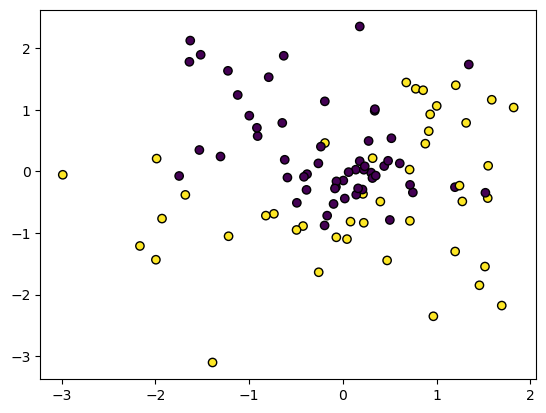

In [2]:
X_train, y_train, X_test, y_test = torch.load("data.pt")
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, edgecolors='k');

Here are definitions of two different feature maps, the "simple" one and the "quadratic" one.

They define feature spaces in $\mathbb{R}^3$ and $\mathbb{R}^6$, respectively.

In [3]:
def features_simple(X):
    return torch.concat((torch.ones_like(X[:,:1]), X), -1)

def features_quadratic(X):
    interactions = X.prod(-1, keepdim=True)
    return torch.concat((torch.ones_like(X[:,:1]), 
                         X, X.pow(2), interactions), -1)

print("Dimension of Phi, `features_simple`:", features_simple(X_train).shape)
print("Dimension of Phi, `features_quadratic`:", features_quadratic(X_train).shape)

Dimension of Phi, `features_simple`: torch.Size([100, 3])
Dimension of Phi, `features_quadratic`: torch.Size([100, 6])


# TASK #1 (3 points): Define the model

The Bayesian logistic regression model we are working with has the form
$$\begin{align*}
\mathbf{w} &\sim \mathcal{N}(0, \sigma^2 \mathbf{I}) \\
\hat y_i &= \mathrm{Logistic}(\mathbf{w}^\top \phi(\mathbf{x}_i)) \\
y_i &\sim \mathrm{Bernoulli}(\hat y_i)
\end{align*}$$
where $i = 1,\dots, N$ and the Logistic function is defined
$$\begin{align*}
\mathrm{Logistic}(z) &= \frac{1}{1 + \exp\{-z\}}.
\end{align*}$$
It's implemented in pytorch as `torch.sigmoid`.

The first step is to define two functions, one to make predictions given a weight vector $\mathbf{w}$ and inputs $\Phi$, and one which computes the log joint probability

$$\log p(\mathbf{y}, \mathbf{w} | \mathbf{\Phi}, \sigma^2).$$

I've done the first one for you.

In [4]:
def predict_probs_MAP(Phi, w):
    """
    Given a "design matrix" Phi, and a point estimate w, compute p(y = 1 | Phi, w)
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    w     : (D,) vector of weights

    OUTPUT:
    y_hat : (N,) vector of probabilities p(y=1 | Phi, w)
    """
    return torch.sigmoid(Phi @ w)

In [5]:
def log_joint(Phi, y, w, sigma=10):
    """
    Compute the joint probability of the data and the latent variables.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones
    w     : (D,) vector of weights
    sigma : scalar, standard deviation of Gaussian prior distribution p(w).
            Leave this set to sigma=10 for purposes of this exercise

    OUTPUT:
    log_joint : the log probability log p(y, w | Phi, sigma), a torch scalar
        
    """

    # YOUR CODE HERE
    log_prior_w = dist.MultivariateNormal(torch.zeros(w.shape[0]), sigma**2*torch.eye(w.shape[0])).log_prob(w)  #sigma**2

    yhat = predict_probs_MAP(Phi, w)
    log_likelihood = dist.Bernoulli(yhat).log_prob(y).sum(0)
    
    # log_likelihood = dist.Normal(mu,sigma).log_prob(x).sum()
    return log_prior_w  + log_likelihood
    

In [6]:
# (GRADING)

In [7]:
# (GRADING)

# TASK 2 (5 points): Implement MAP estimation

Now you need to write a function which performs MAP estimation, i.e. penalized maximum likelihood estimation.

This function should find the value $\mathbf{w}_{MAP}$ that maximizes the log joint, i.e.

$$\mathbf{w}_{MAP} = \mathrm{argmax}_{\mathbf{w}}\log p(\mathbf{y}, \mathbf{w} | \mathbf{\Phi}, \sigma^2).$$

To do this, you should **use pytorch autograd tools**. This will involve defining an initial value of the weights, computing a scalar loss function, and calling `.backward()`, and then performing gradient-based optimization. Take a look at the demo notebooks from previous lectures for examples…!

* You **may feel free to use classes from `torch.optim`**. I would suggest the use of `torch.optim.SGD` or `torch.optim.Adagrad`.
* Regardless of how you do this, you will need to decide on a stopping criteria for your optimization routine.
* You will also need to decide on how to set the parameters (learning rate, momentum, anything else!) for your selected optimizer.

Also, **your code should work for ANY features!**. We will test this out on not just the "simple" and "quadratic" features above, but also on your own custom choice of features.

In [8]:
def find_MAP(Phi, y):
    """
    Find the MAP estimate of the log_joint method.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones


    OUTPUT:
    w      : (D,) vector of optimized weights
    losses : list of losses at each iteration of the optimization algorithm.
             Should be a list of scalars, which can be plotted afterward to
             diagnose convergence.
    """

    weights = torch.zeros(Phi.shape[1]).requires_grad_(True)
    losses = []
    
    # YOUR CODE HERE
    # raise NotImplementedError()

    opt = torch.optim.SGD((weights, ), lr=0.01, momentum=0.8)
    # iterate
    N_steps = 300
    for _ in range(N_steps):
        # zero the gradients
        opt.zero_grad()
        # forward pass
        loss = -log_joint(Phi, y, weights) 
        # print(loss)
        # print(log_joint(Phi, y, weights))
        # backward pass
        loss.backward()
        # save value for reference (`.item()` returns the raw scalar!)
        losses.append(loss.detach().numpy()) #TODO: why detach - matplotlib version
        # do one optmizer step
        opt.step()

    return weights.detach(), losses


### The following two cells call `find_MAP` to compute $\mathbf{w}$ for both choices of features.

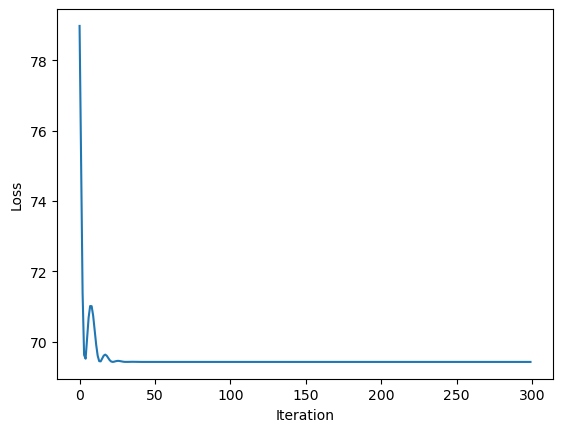

In [9]:
w_MAP_simple, losses = find_MAP(features_simple(X_train), y_train)
plt.plot(losses);
plt.xlabel("Iteration")
plt.ylabel("Loss");

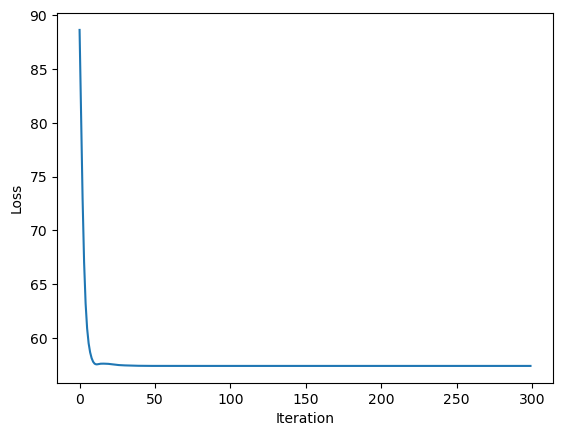

In [10]:
w_MAP_quad, losses = find_MAP(features_quadratic(X_train), y_train)
plt.plot(losses);
plt.xlabel("Iteration")
plt.ylabel("Loss");

In [11]:
# (GRADING)

In [12]:
# (GRADING)

## Visualization: The following code visualizes the classifier result

It plots the probability of being one class or the other using a color contour plot.

The decision boundary is a dashed black line.

In [13]:
def plot_boundary(X, y, pred):
    h = 0.2
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = pred(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=.8, levels=np.linspace(0, 1, 8))
    
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    
    plt.contour(xx, yy, Z, levels=(0.5,), linestyles='dashed');
    
    # Plot the testing points
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())

Simple features: training accuracy = 0.68, test accuracy = 0.68


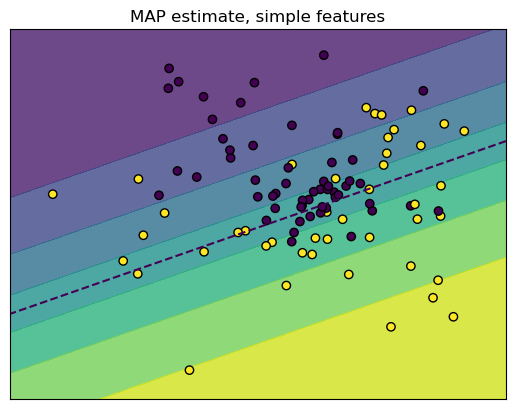

In [14]:
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_simple(X), w_MAP_simple))
plt.title("MAP estimate, simple features")
train_accuracy = (predict_probs_MAP(features_simple(X_train), w_MAP_simple).round() == y_train).float().mean()
test_accuracy = (predict_probs_MAP(features_simple(X_test), w_MAP_simple).round() == y_test).float().mean()
print("Simple features: training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))

Polynomial features: training accuracy = 0.86, test accuracy = 0.92


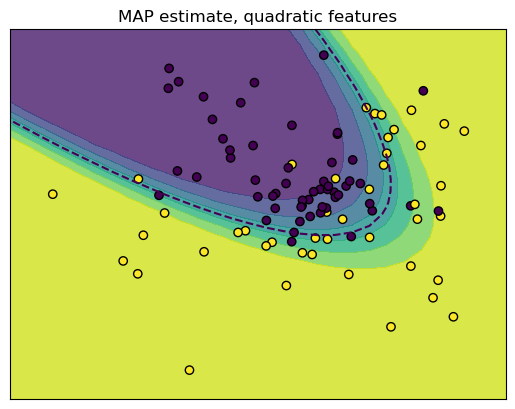

In [15]:
plot_boundary(X_train, y_train,
              lambda X: predict_probs_MAP(features_quadratic(X), w_MAP_quad))
plt.title("MAP estimate, quadratic features")
train_accuracy = (predict_probs_MAP(features_quadratic(X_train), w_MAP_quad).round() == y_train).float().mean()
test_accuracy = (predict_probs_MAP(features_quadratic(X_test), w_MAP_quad).round() == y_test).float().mean()
print("Polynomial features: training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))

# TASK #3 (5 points): Laplace approximation

In the next section, you will fit an approximate posterior over the weights by using the Laplace approximation around the mode $\mathbf{w}_{MAP}$ of the distribution you found above.

This requires completing two functions:

1. `compute_laplace_Cov` takes the data and the MAP estimate, and outputs a covariance matrix defined as the negative inverse Hessian of the log target density. (See the week 4 lecture slides for details on how to compute this!)
2. `predict_bayes` makes predictions on new data points, by approximating $\int p(y | x, w)p(w | \mathcal{D})dw$ when using a Gaussian approximation to $p(w | \mathcal{D})$. In the week 4 lecture slides we discussed three different ways of computing this — it is up to you to decide what method you would prefer, and implement it.

In [16]:
def compute_laplace_Cov(Phi, y, w_MAP, prior_std=10):
    """
    Compute the Laplace approximation of the posterior covariance 
    in a logistic regression setting.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones
    w_MAP : (D,) vector of optimized weights, at a mode of the target density
    sigma : scalar, standard deviation of Gaussian prior distribution p(w).
            Leave this set to sigma=10 for purposes of this exercise

    OUTPUT:
    Cov : (D, D) posterior covariance matrix estimate defined by the Laplace 
          approximation
    """
    
    # YOUR CODE HERE
    # raise NotImplementedError()
    
    y_hat = predict_probs_MAP(Phi, w_MAP)
    # print(y_hat.shape)
    D = w_MAP.shape[0]
    weighted_sum = torch.zeros((D, D))
    for i in range(len(y)):
        p_i = y_hat[i]
        phi_i = Phi[i].unsqueeze(1)  # Making Phi[i] a column vector
        weighted_sum += p_i * (1 - p_i) * (phi_i @ phi_i.T)

    prior_precision = 1 / prior_std**2
    S_0_inv = torch.eye(D) * prior_precision
    return torch.inverse(S_0_inv + weighted_sum)


In [17]:
def predict_bayes(Phi, w_MAP, Cov):
    """
    Make predictions on new data points using an approximate posterior 
    w ~ MultivariateNormal(w_MAP, Cov)
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    w_MAP : (D,) vector of optimized weights, at a mode of the target density
    Cov   : (D, D) approximate posterior covariance matrix
    
    OUTPUT:
    y_hat : (N,) vector of probabilities p(y=1 | Phi)
    """
    
    # YOUR CODE HERE
    # raise NotImplementedError()
    # return ...
    preds = []
    N=len(Phi)
    for i in range(N):
        phi_i = Phi[i]
        mu_a = phi_i @ w_MAP
        sigma_square_a = phi_i @ (Cov @ phi_i.T)
        pred = torch.sigmoid( mu_a / (1 + (torch.pi * sigma_square_a/8) )**(1/2))
        preds.append(pred)
    return np.array(preds)

### The following cells call your functions above to compute the Laplace approximation and visualize the posterior predictive distribution.

In [18]:
Cov_simple = compute_laplace_Cov(features_simple(X_train), y_train, w_MAP_simple)

C:\Users\sruth\AppData\Local\Temp\ipykernel_7120\2478181347.py:24: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3618.)
  sigma_square_a = phi_i @ (Cov @ phi_i.T)


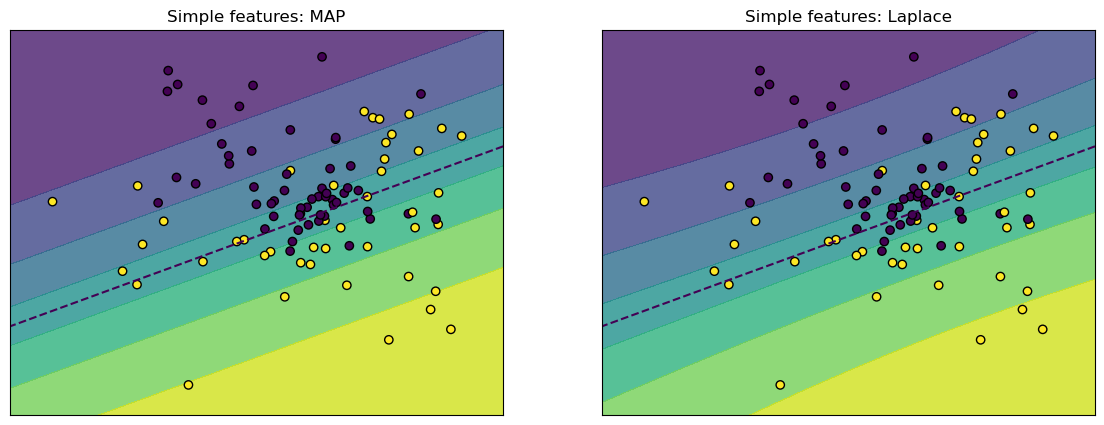

In [19]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title("Simple features: MAP")
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_simple(X), w_MAP_simple))

plt.subplot(122)
plt.title("Simple features: Laplace")
plot_boundary(X_train, y_train, 
              lambda X: predict_bayes(features_simple(X), w_MAP_simple, Cov_simple))

In [20]:
Cov_quad = compute_laplace_Cov(features_quadratic(X_train), y_train, w_MAP_quad)

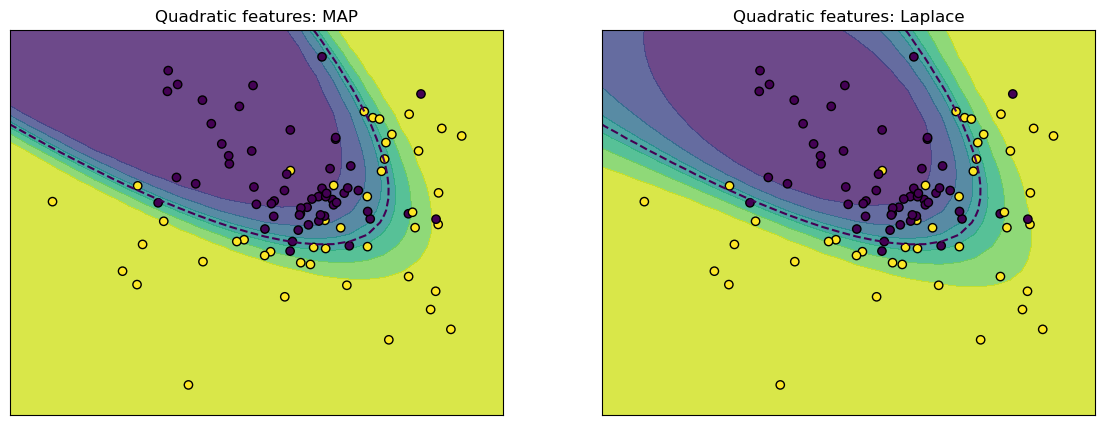

In [21]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title("Quadratic features: MAP")
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_quadratic(X), w_MAP_quad))

plt.subplot(122)
plt.title("Quadratic features: Laplace")
plot_boundary(X_train, y_train, 
              lambda X: predict_bayes(features_quadratic(X), w_MAP_quad, Cov_quad))

In [22]:
# (GRADING)

In [23]:
# (GRADING)

In [24]:
# (GRADING)

# TASK #4 (2 points): Model comparison

You can compute the marginal likelihood approximation defined by the Laplace approximation.

This estimate of the evidence can be used, even just looking at the training data, to help decide which of the two feature maps is more appropriate and better fits the data.

This can help guard against potential overfitting if using features that are "too complex".

In [25]:
def compute_laplace_log_evidence(Phi, y, w_MAP, Cov):
    """
    This computes the Laplace approximation to the marginal likelihood,
    as defined in the Week 5 lectures.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones
    w_MAP : (D,) vector of optimized weights, at a mode of the target density
    Cov   : (D, D) approximate posterior covariance matrix
    
    OUTPUT:
    log_evidence : scalar value estimating `log p(y | Phi)`
    """
    
    # YOUR CODE HERE
    # raise NotImplementedError()
    # return ...
    term1_plus_term2 = log_joint(Phi, y, w_MAP)

    #     occam_factor_term2 = (y/2) * torch.log(torch.tensor(2 * torch.pi))
    D = w_MAP.shape[0]
    occam_factor_term2 = 0.5 * D * torch.log(torch.tensor(2 * torch.pi)) #normalization_constant
    occam_factor_term3 = - 0.5 * torch.logdet(torch.inverse(Cov))
    # occam_factor_term3 = -0.5 * torch.logdet(Cov) #complexity_penalty

    # print(term1_plus_term2, occam_factor_term2, occam_factor_term3)
    # print('Shapes ',log_likelihood.shape, occam_factor_term2.shape )
    log_evidence = term1_plus_term2 + occam_factor_term2 + occam_factor_term3

    return log_evidence #.item()  # Return as a scalar

In [26]:
print("Model evidence estimate (simple features):",
      compute_laplace_log_evidence(features_simple(X_train), y_train, w_MAP_simple, Cov_simple).item())

print("Model evidence estimate (polynomial features):",
      compute_laplace_log_evidence(features_quadratic(X_train), y_train, w_MAP_quad, Cov_quad).item())

Model evidence estimate (simple features): -70.93085479736328
Model evidence estimate (polynomial features): -57.52265167236328


In [27]:
# (GRADING)

# TASK #5 (2 points + 4 points): Define your own feature space

Your next task is to define your own, custom feature space! This can be practically any deterministic function from $\mathbb{R}^2$ to $\mathbb{R}^D$, and you even get to pick the dimensionality $D$.

In the following cells, you first define your feature space, and then we estimate the posterior using your code above. We report training accuracy, test accuracy, and model evidence, as well as plot the decision boundaries.

Feel free to get quite creative here! However, you will be asked to defend your choice of feature space in the free-answer section at the bottom.

**Make sure when you submit, you include whatever you consider the "best" possible choice!**

In [28]:
def features_student(X):
    """
    Compute your own, custom set of features!
    
    INPUT:
    X      : (N, 2) tensor of raw input data
    
    OUTPUT:
    Phi    : (N, D) tensor of transformed inputs
    """
    
    # YOUR CODE HERE
    # raise NotImplementedError()

    interactions = X.prod(-1, keepdim=True)
    return torch.concat((torch.ones_like(X[:,:1]), 
                         X, X.pow(2), X.pow(3), interactions), -1)
    # return ...
    

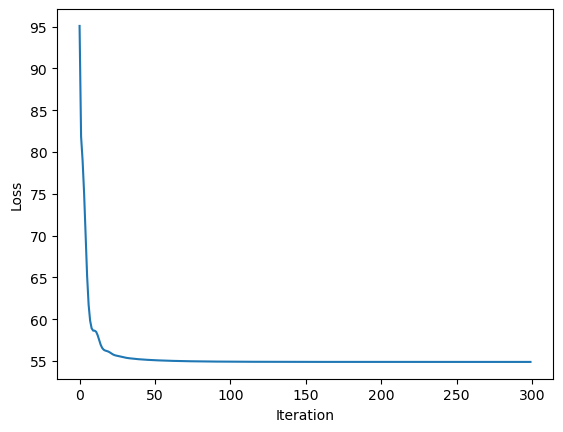

In [29]:
w_MAP_student, losses = find_MAP(features_student(X_train), y_train)
plt.plot(losses);
plt.xlabel("Iteration")
plt.ylabel("Loss");

In [30]:
train_accuracy = (predict_probs_MAP(features_student(X_train), w_MAP_student).round() == y_train).float().mean()
test_accuracy = (predict_probs_MAP(features_student(X_test), w_MAP_student).round() == y_test).float().mean()
print("YOUR features! Training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))

YOUR features! Training accuracy = 0.86, test accuracy = 0.92


In [31]:
Cov_student = compute_laplace_Cov(features_student(X_train), y_train, w_MAP_student)

print("YOUR features! Model evidence estimate:",
      compute_laplace_log_evidence(features_student(X_train), y_train, w_MAP_student, Cov_student).item())

YOUR features! Model evidence estimate: -52.30931854248047


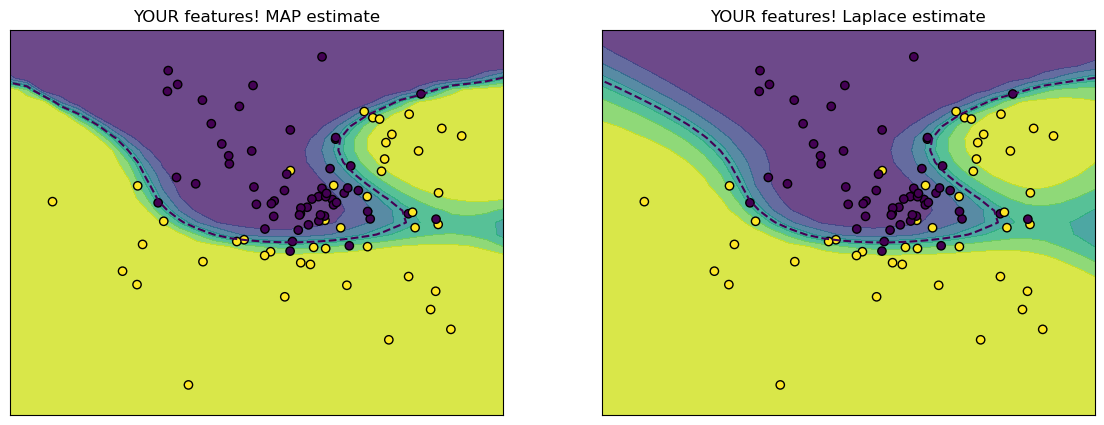

In [32]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title("YOUR features! MAP estimate")
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_student(X), w_MAP_student))

plt.subplot(122)
plt.title("YOUR features! Laplace estimate")
plot_boundary(X_train, y_train, 
              lambda X: predict_bayes(features_student(X), w_MAP_student, Cov_student))

# Please answer the following short questions:

1. *[Feature selection]* How did you choose your features? Name at least two ways of comparing whether one set of features is "better" than another. Would these methods generally yield the same "ranking" of different features? Why or why not?
2. *[Overfitting]* Is "overfitting" possible in this setting? Did you experience it? If so, how would you detect it? Does using the Laplace approximation "help" with overfitting, or does it not make a difference? Justify your answer.

YOUR ANSWER HERE

Answer 1. 

Since the data is not linearly separable in R^2 (by looking at the image), we can choose transformations which would allow linear separation in higher dimensions. By choosing polynomial features with interaction terms, we see that the classes can be separated. However, with higher dimensions, the model may overfit to the data, and hence we have to ensure that the model is not too complex.

The two ways of comparing the models could be (1) Test accuracy and (2) Model evidence 
(1) Test Accuracy - The model with the higher accuracy on test data would have a higher ranking in this method
(2) Model evidence - this estimate depends on factors such as the priors and complexity - since it takes the "occam's razor" effect as a factor, it favors simpler models. Higher number of features may not be better unless it leads to sufficiently better predictions to outweigh the increased complexity.
These two methods may not have the same ranking 
Example:

a) Simple features:  test accuracy = 0.68 , Model evidence estimate: -70.93

b) Polynomial features: test accuracy = 0.92, Model evidence estimate: -57.5

c) My features: test accuracy = 0.92, Model evidence estimate: -52.3

Here, according to the accuracy criterion, polynomial features and my features have the same ranking, which is higher than that of simple features. However, according to the log evidence criterion, my features are better than polynomial features


Answer 2. Overfitting 

Overfitting is possible in this setting if we use very complex feature sets relative to the data, since the model would fit the noise. Overfitting was experienced with higher polynomials of order 5, which gave test accuracy that was much lower than the train accuracy. 

The Laplace approximation provides a sort of regularization for our model by approximating the curvature (hessian) of the log-posterior around the MAP estimate. It doesn't directly address overfitting but it provides a measure of the uncertainty in the parameter estimates, and thus the predictive distribution obtained using Laplace approximation generates more conservative predictions than just using the MAP estimate alone. 

#### Ignore the following cells. They are used by the grading system.

In [33]:
# (GRADING)

In [34]:
# (GRADING)